In [1]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [1]:
###import modules
import os
import numpy as np
import pandas as pd; pd.set_option('max_rows', 3, 'max_colwidth',-1, 'max_columns', 20)
# import matplotlib
# matplotlib.use('Qt5Agg') 
#if plotting in a separate window is needed, like for ginput()
#otherwise, to pltot inline, activate "inline" or "notebook" / "nbagg" for interactive plots
%matplotlib notebook
import matplotlib.pyplot as plt

import seaborn as sns; sns.set_style('darkgrid')
# sns.set(rc = {'figure.figsize' : (8.0, 6.0)})
from scipy import stats
import itertools
from sklearn.cluster import DBSCAN

###import and set display and plotting styles
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import ColumnDataSource, DataTable, TableColumn, HoverTool, PointDrawTool, \
Legend, Arrow, NormalHead, Range1d
from bokeh.models.annotations import Label
from bokeh.palettes import Blues, Oranges, Viridis, Magma
from bokeh.layouts import row, Column
output_notebook(hide_banner=True)

In [2]:
def get_middle_coords(filename, center_zoom_factor=0.05 ):
    '''read storm coordinate file and crop data by center_zoom_factor: 
    Returns:
    1: whole cropped dataset as pandas dataframe
    2: cropped [[Xwc, Ywc, Zc]] values as numpy arrays
    '''
    
    #read data as pandas dataframes and get xyz values as numpy arrays 
    dt = pd.read_csv(filename, delimiter='\t')
    dt = dt[dt['Channel Name'].astype(str) != 'Z Rejected'] 

    xyz = dt[['Xwc','Ywc', 'Zc']].values
    #crop specified area of image
    if center_zoom_factor:
        box = np.array([np.min(xyz, axis=0),
                         np.max(xyz, axis=0)])
        box_center = 0.5 * (box[0, :] + box[1, :])
        box_edges = box[1, :] - box[0, :]
        factor = center_zoom_factor * 0.5
        crop_box = np.array([box_center - factor * box_edges,
                             box_center + factor * box_edges])
        greater_mask = np.all(crop_box[0, :2] < xyz[:, :2], axis=1)
        less_mask = np.all(xyz[:, :2] < crop_box[1, :2], axis=1)
        xyz = xyz[greater_mask * less_mask, :]
    return dt, xyz

In [3]:
def add_layer_numbers (dt):
    '''Given a merged storm z-stack txt without layer numberings, add layer numbers to a new column named 'layer'.
    Input: storm data as pandas dataframe, having column named 'Frame'.
    Returns: storm data as dataframe with the extra column.
    '''
    
    prev_frame = 1
    curr_layer = 1
    layers = pd.DataFrame(np.zeros(len(dt)), columns=['Layer_number'])
    for i, frame in enumerate(dt['Frame']):
        if frame < prev_frame:    #new layer started 
            curr_layer+=1
        layers.iloc[i] = curr_layer
        prev_frame = frame
    dt = pd.concat([dt, layers], axis=1)
    return dt

## -> Get data for example mito 

In [4]:
path = "L:/Miki/STORM_projects/190301_z-stack_mitochondrium/example//"
fname = "TOM20_sl01_z_s001_ZStack (7 files Z stack).txt"
mito = "__TOM20_sl01_z_s001_ZStack (7 files Z stack)_freehandROI_1_RoiCoords.txt"
# dt, xyz = get_middle_coords(path+mito)

In [5]:
dt = pd.read_csv(path+mito, delimiter='\t')
dt = dt[dt['Channel Name'].astype(str) != 'Z Rejected'] 
dt = add_layer_numbers(dt)
layer = dt['Layer_number']
xyz = dt[['Xwc','Ywc', 'Zc']].values
dt

,Channel Name,X,Y,Xc,Yc,Height,Area,Width,Phi,Ax,...,Zc,Photons,Lateral Localization Accuracy,Xw,Yw,Xwc,Ywc,Zw,Zwc,Layer_number
0,647,23952.3,24834.3,23952.3,24834.3,1268.51563,7922.39648,319.01602,0.27100,0.98435,...,608.019,694.53036,13.21455,23952.3,24834.3,23952.3,24834.3,608.0,608.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,647,23956.7,24083.9,23972.1,24085.9,765.89233,7134.33643,389.84454,1.03397,1.45417,...,1344.440,625.44373,19.67842,23956.7,24083.9,23972.1,24085.9,1345.3,1345.3,7.0


## -> Plot an example mito

In [7]:
#bokeh plot xy, xz, yz views
scaling = False #or by 0.79, see Huang et al. 
# bokeh_fig_defaults = dict(match_aspect=True, x_axis_label='x-coordinates', y_axis_label='y-coordinates')
p1 = figure(title = "xy view", match_aspect=True, x_axis_label='x-coordinates', y_axis_label='y-coordinates',
           plot_width=450, plot_height=450)
p2 = figure(title = "zy view", match_aspect=True, x_axis_label='z-coordinates', y_axis_label='y-coordinates', 
            plot_width=450, plot_height=450, y_range=p1.y_range) #or disable sharing ranges not to link plots
p3 = figure(title = "xz view", match_aspect=True, x_axis_label='x-coordinates', y_axis_label='z-coordinates', 
            plot_width=450, plot_height=450, x_range=p1.x_range)

for curr_layer, color in zip(np.unique(layer), itertools.cycle(Magma[10])):
    curr_dt = dt[dt['Layer_number'] == curr_layer] #filter for specified layer
    curr_xyz = curr_dt[['Xwc','Ywc', 'Zc']].values
    if scaling: 
        curr_xyz[:,2] *= 0.72 #modify only z-coordinates by the scaling factor
    p1.scatter(curr_xyz[:,0], curr_xyz[:,1], fill_color=color, size=10, legend=str(curr_layer))
    p2.scatter(curr_xyz[:,2], curr_xyz[:,1], fill_color=color, size=10, legend=str(curr_layer))
    p3.scatter(curr_xyz[:,0], curr_xyz[:,2], fill_color=color, size=10, legend=str(curr_layer))
    
p1.legend.click_policy = 'hide'
p2.legend.click_policy = 'hide'
p3.legend.click_policy = 'hide'

grid =  gridplot([[p1, p2], [p3, None]])
show(grid)
# show(p1)
# show(row(p2,p3))

 __No scaling is neede (as in Huang et al., 2008)__

## --> Select points by hand

In [6]:
import sl_mod_miki as sl
from matplotlib.path import Path

In [9]:
# #do it in separate window, otherwise ginput() does not work in Jupyter
# #other backends will not work (like notebook), restart kernel for enabling them
# #terminate selections with middle click of the mouse!
# %matplotlib qt
# from matplotlib.path import Path
# fig, ax = plt.subplots(figsize=(10,10))
# scatter = ax.scatter(xyz[:,0], xyz[:,1], s=10, c='purple')
# ax.set_aspect(1.0)
# #draw polygon around points
# points_xy = plt.ginput(n=-1, timeout=-1, show_clicks=True, mouse_stop=2)
# # ax.figure.canvas.draw()
# plt.plot([x[0] for x in points_xy], [y[1] for y in points_xy])
# points_xy = np.array(points_xy)
# polygon = Path(points_xy)
# contain = polygon.contains_points(xyz[:,0:2])
# filtered_xyz = xyz[contain]

# #clear existing data and out the selected ones
# # ax.clear()
# # ax.scatter(filtered_xyz[:,0], filtered_xyz[:,1], s=10, c='green')


In [10]:
# import matplotlib.pyplot as plt
# class LineDrawer(object):
#     lines = []
#     def draw_line(self):
#         ax = plt.gca()
#         xy = plt.ginput(n=-1, timeout=-1, show_clicks=True, mouse_stop=2)
#         x = [p[0] for p in xy]
#         y = [p[1] for p in xy]
#         line = plt.plot(x,y)
#         ax.figure.canvas.draw()
#         self.lines.append(line)
#         return xy

In [7]:
# import matplotlib.pyplot as plt
# %matplotlib qt

# def handle_close(event):
#     plt.close()
#     fig_on = False
    
# fig = plt.figure()
# fig.canvas.mpl_connect('close_event', handle_close)
# if not plt.fignum_exists(fig.number):
#     print "no"
    



# print "closed"

<IPython.core.display.Javascript object>


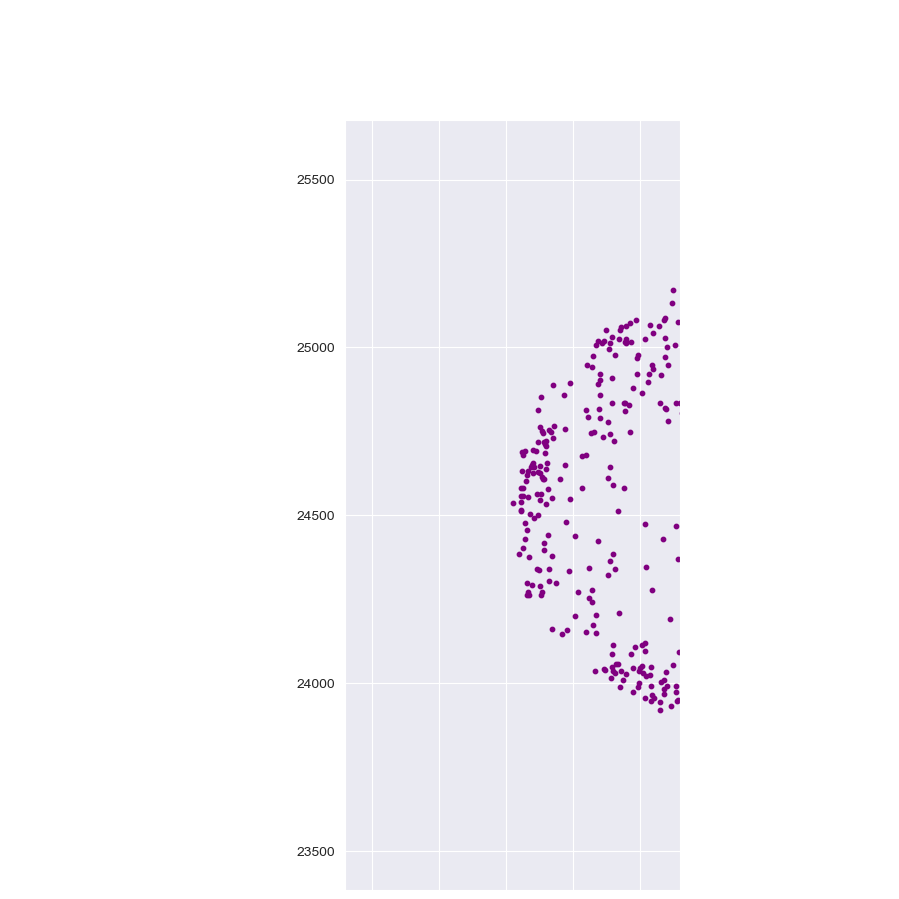

In [ ]:
# ### how sl would do it
#
# %matplotlib qt
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(xyz[:,0], xyz[:,1], s=10, c='purple')
xmin, xmax = xyz[:,0].min(), xyz[:,0].max()
ymin, ymax = xyz[:,1].min(), xyz[:,1].max()
plt.xlim((xmin-500, xmin+500))
plt.ylim((ymin-500, ymax+500))
ax.set_aspect(1.0)
#instantiate sl drawROI class and get callbacks
cursor=sl.drawROI(ax,fig)
fig.canvas.mpl_connect('motion_notify_event', cursor.motion_notify_callback)
fig.canvas.mpl_connect('button_press_event', cursor.button_press_callback)
fig.canvas.mpl_connect('key_press_event', cursor.key_press_callback)

# script continues ONLY, if a button was pressed 
# closing the figure manually does NOT work, kernel dies
while True:
    if plt.waitforbuttonpress():
        break



points_xy = cursor.lassocoordset
print "closed"   
if len(points_xy) == 0:
    print "aaaa"
points_xy = np.array(points_xy)
points_xy = np.squeeze(points_xy)
polygon = Path(points_xy)
contain = polygon.contains_points(xyz[:,0:2])
filtered_xyz = xyz[contain]
nonFiltered_xyz = xyz[np.logical_not(contain)]
filtered_dt = dt[contain]
# ax.scatter(filtered_xyz[:,0], filtered_xyz[:,1], s=10, c='purple')
ax.scatter(nonFiltered_xyz[:,0], nonFiltered_xyz[:,1], s=10, c='white', alpha=0.7)


In [24]:
cursor.trash

False

In [ ]:
def filter_points_2D(xyz):
    try:
        %matplotlib qt
    except:
        print "problem with backends"
    fig, ax = plt.subplots(figsize=(10,10))
    scatter = ax.scatter(xyz[:,0], xyz[:,1], s=10, c='purple')
    ax.set_aspect(1.0)
    cursor=sl.drawROI(ax,fig)
    fig.canvas.mpl_connect('motion_notify_event', cursor.motion_notify_callback)
    fig.canvas.mpl_connect('button_press_event', cursor.button_press_callback)
    fig.canvas.mpl_connect('key_press_event', cursor.key_press_callback)

    while True:
        points_xy = cursor.lassocoordset

        if plt.waitforbuttonpress():
            break
    # if len(points_xy) != 0:
    #     print "aaaa"
    points_xy = np.array(points_xy)
    points_xy = np.squeeze(points_xy)
    polygon = Path(points_xy)
    contain = polygon.contains_points(xyz[:,0:2])
    filtered_xyz = xyz[contain]
    nonFiltered_xyz = xyz[np.logical_not(contain)]
    filtered_dt = dt[contain]
    # ax.scatter(filtered_xyz[:,0], filtered_xyz[:,1], s=10, c='purple')
    ax.scatter(nonFiltered_xyz[:,0], nonFiltered_xyz[:,1], s=10, c='white', alpha=0.7)


In [ ]:
%matplotlib qt
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(filtered_xyz[:,0], filtered_xyz[:,1], s=10, c='purple')
ax.scatter(nonFiltered_xyz[:,0], nonFiltered_xyz[:,1], s=10, c='black')

## -> 3D plot with matplotlib Axes3D

In [ ]:
%matplotlib notebook
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter (xyz[:,0], xyz[:,1], xyz[:,2], s=45, c='purple', depthshade=True)
ax.set_xlabel('x', labelpad=10, fontsize=18), ax.set_ylabel('y', labelpad=10, fontsize=18), ax.set_zlabel('z', labelpad=10, fontsize=18)
plt.tight_layout();
# plt.savefig(path+"_mito3d");

In [ ]:
### 
### https://stackoverflow.com/questions/21339448/how-to-get-list-of-points-inside-a-polygon-in-python
###

# from matplotlib.path import Path
# np.set_printoptions(threshold=np.inf)#sys.maxsize)

# tupVerts=[(86, 52), (85, 52), (81, 53), (80, 52), (79, 48), (81, 49), (86, 53),
#  (85, 51), (82, 54), (84, 54), (83, 49), (81, 52), (80, 50), (81, 48),
#  (85, 50), (86, 54), (85, 54), (80, 48), (79, 50), (85, 49), (80, 51),
#  (85, 53), (82, 49), (83, 54), (82, 53), (84, 49), (79, 49)]


# x, y = np.meshgrid(np.arange(300), np.arange(300)) # make a canvas with coordinates
# x, y = x.flatten(), y.flatten()
# points = np.vstack((x,y)).T 
# p = Path(tupVerts) # make a polygon
# grid = p.contains_points(points)
# mask = grid.reshape(300,300) # now you have a mask with points inside a polygon


***
## <font color='red'> OTHER: PFS extent vs Z and coverglass positions </font>
***

In [ ]:
pos_data = pd.read_excel(path+"_z_positions_calc.xlsx")
pos_data

In [ ]:
PFS_extent = pos_data["PFS_extent(last)"].values 
PFS_bottom = pos_data["PFS_bottom"].values
PFS_CGP = pos_data["CGP_PFS(first_layer)"].values #CoverGlassPosition
PFS_CGP_diff = pos_data["CGP_distance_PFS"].values #distance of first data form CGP

Z_extent_orig = pos_data["Z_extent(orig)"].values #based on Z-pos set originally
Z_extent_last = pos_data["Z_extent(last)"].values #based on last Z position
Z_bottom = pos_data["Z_bottom"].values
Z_CGP = pos_data["CGP_Z(first_layer)"].values
Z_CGP_diff = pos_data["CGP_distance_Z"].values

In [ ]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots (1,3, figsize= (20,5), sharey=True)
ax1.scatter(PFS_bottom, PFS_extent, s=50)
ax1.set_ylabel("PFS extent", fontsize=20, labelpad=20)
ax1.set_xlabel("PFS bottom", fontsize=20, labelpad=20)

ax2.scatter(PFS_CGP, PFS_extent, s=50)
ax2.set_xlabel("PFS CoverGlassPosition", fontsize=20, labelpad=20)

ax3.scatter(PFS_CGP_diff, PFS_extent, s=50)
ax3.set_xlabel("PFS DistanceFromCoverGlass", fontsize=20, labelpad=20)

for ax in fig.axes:
    ax.tick_params(axis='both', labelsize=15)
    


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots (1,3, figsize= (20,5), sharey=True)

ax1.scatter(Z_bottom, Z_extent_orig, s=50)
ax1.set_ylabel("Z extent (original)", fontsize=20, labelpad=20)
ax1.set_xlabel("Z bottom", fontsize=20, labelpad=20)

ax2.scatter(Z_CGP, Z_extent_orig, s=50)
ax2.set_xlabel("Z CoverGlassPosition", fontsize=20, labelpad=20)

ax3.scatter(Z_CGP_diff, Z_extent_orig, s=50)
ax3.set_xlabel("Z DistanceFromCoverGlass", fontsize=20, labelpad=20)

for ax in fig.axes:
    ax.tick_params(axis='both', labelsize=15)

fig, (ax1, ax2, ax3) = plt.subplots (1,3, figsize= (20,5), sharey=True)

ax1.scatter(Z_bottom, Z_extent_last, s=50)
ax1.set_ylabel("Z extent (real)", fontsize=20, labelpad=20)
ax1.set_xlabel("Z bottom", fontsize=20, labelpad=20)

ax2.scatter(Z_CGP, Z_extent_last, s=50)
ax2.set_xlabel("Z CoverGlassPosition", fontsize=20, labelpad=20)

ax3.scatter(Z_CGP_diff, Z_extent_last, s=50)
ax3.set_xlabel("Z DistanceFromCoverGlass", fontsize=20, labelpad=20)

for ax in fig.axes:
    ax.tick_params(axis='both', labelsize=15)

***
## <font color='red'> Trials for density based coloring </font>
***

In [ ]:
# from scipy.interpolate import griddata
# fig = plt.figure(figsize=(8,8))
# ax = fig.gca(projection='3d')
# x2, y2 = np.meshgrid(xyz[:,0], xyz[:,1])
# z2 = griddata((xyz[:,0], xyz[:,1]), xyz[:,2], (x2, y2), method='cubic')
# surf = ax.plot_surface (x2, y2, z2,  color='purple', rcount=50, shade=True)

In [ ]:
###matplotlib plot
# n = 10 #number of colors to iterate over
# colors = plt.cm.viridis(np.linspace(0,1,10))
# fig, ax = plt.subplots(figsize = (6,6))
# for curr_layer, color in zip(np.unique(layer), colors):
#     curr_xyz = dt[dt['layer'] == curr_layer] #filter for specified layer
#     curr_xyz = curr_xyz[['Xwc','Ywc', 'Zc']].values
#     ax.scatter(curr_xyz[:,0],curr_xyz[:,1], c=color, label=str(curr_layer))

# ax.set_aspect('equal')
# plt.legend(loc='upper right');

In [ ]:
###random points for trial plots
x = np.random.randint(100, size=(1, 500))
y = np.random.randint(100, size=(1, 500))

fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(x,y, s = 5);

In [ ]:
###density_based_coloring
#get restructured data 
import scipy.spatial as spatial
xy = np.concatenate((x,y))
xy = xy.T
#get KDtree and point numbers within epsilon from point in KDtree
tree = spatial.KDTree(xy)
eps = 10
neighbors = []
for i in tree.data:
    n = len(tree.query_ball_point(i, eps))-1
    neighbors.append(n)
#get points below/above specified vutoff value (mean dens)
mean = np.mean(neighbors)
normed_neighbors = np.array(neighbors)/mean

#plot data
fig, ax = plt.subplots(figsize = (6,6))
for i, dens in zip(xy, normed_neighbors):
    if dens < 1:
        color = 'green'
    if dens >=1:
        color = 'red'
    ax.scatter(i[0], i[1], s=5, c=color)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
t = np.arange(10)
plt.plot(t, np.sin(t))
print("Please click")
x = plt.ginput(3)
print("clicked", x)
plt.show()

In [25]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.random.rand(10))
text=ax.text(0,0, "", va="bottom", ha="left")

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

***
## Resources 
***

### 3D plots
- https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
- https://stackoverflow.com/questions/9170838/surface-plots-in-matplotlib- 
- https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
- plotly: https://plot.ly/python/3d-scatter-plots/
- Ipyvolume: bokeh / pyqt should be downgraded from 1.x -> 0.x / 5.x -> 4.x

### interactive matplotlib plots in Jupyter notebook 
- https://www.reddit.com/r/IPython/comments/36p360/try_matplotlib_notebook_for_interactive_plots/
- https://matplotlib.org/users/navigation_toolbar.html
- clicking on/off legends via matplotlib: https://matplotlib.org/gallery/event_handling/legend_picking.html

- handling interactive events: https://stackoverflow.com/questions/43923313/canvas-mpl-connect-in-jupyter-notebook

<br>

- selecting points and printing out their values: https://stackoverflow.com/questions/7969352/matplotlib-interactively-select-points-or-locations
- event demo: https://matplotlib.org/gallery/event_handling/pick_event_demo.html
- draw line or polygons and get their values via ginput: 
    - https://stackoverflow.com/questions/9136938/matplotlib-interactive-graphing-manually-drawing-lines-on-a-graph
    - https://matplotlib.org/api/_as_gen/matplotlib.pyplot.ginput.html
    - https://glowingpython.blogspot.com/2011/08/how-to-use-ginput.html
    - in jupyter: https://stackoverflow.com/questions/41403406/matplotlib-use-of-ginput-on-jupyter-matplotlib-notebook
    <br>
    - maybe better via sl, but:
        - https://matplotlib.org/gallery/event_handling/ginput_manual_clabel_sgskip.html#sphx-glr-gallery-event-handling-ginput-manual-clabel-sgskip-py
- update plot: https://pythonspot.com/matplotlib-update-plot/
- get points inside polygon:  https://stackoverflow.com/questions/21339448/how-to-get-list-of-points-inside-a-polygon-in-python

>br>
- event handling: https://stackoverflow.com/questions/33569626/matplotlib-responding-to-click-events
- lasso selection! https://matplotlib.org/examples/event_handling/lasso_demo.html
### density based coloring
- https://stackoverflow.com/questions/35824882/matplotlib-coloring-scatter-plot-based-on-relative-density
- https://stackoverflow.com/questions/14070565/calculating-point-density-using-python